<a href="https://colab.research.google.com/github/mintycake420/Basic-Exercises-for-courses/blob/main/InformationRetreival_EX04_211718366.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**InformationRetreival_EX04_211718366.ipynb**
# **Co-Occurence Matrix Visulazation** on wikipedia articles related to the mediveal crusader Kingdom of Jerusalem



---

### **Assignment Requirements:**

Task A.1 - Input Preparation: For approximately 30 documents on a general topic of your choice, divide the documents into units of 10 words with jumps of 5 words each time. That is, there should be an overlap of 5 words between each sequence.

Task A.2 - Stop Words Removal: From each sequence of 10 words, remove stop words (you can use nltk).

Task A.3 - Perform Stemming: You can use nltk library

Task A.4: Select the 100 most frequent words as your vocabulary.

Task B - Count Shared Occurrences: A shared occurrence is counted only once per word sequence.

Task C - Present Results: Display the table and an interesting visualization.
---

**Submitted by:** Yotam Katz  
**Date:** November 2025  
**Course:** אחזור מידע 26 3700 א01  
**Lecturer:** Dr. Moshe Friedman  
**ID:** 211718366  
**Email:** Yotamkatz2000@gmail.com

## Step 1: Install and Import Libraries

In [17]:
# Install required libraries
!pip install wikipedia-api nltk -q

import wikipediaapi
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Fetch Wikipedia Articles

In [18]:
# Initialize Wikipedia API
wiki = wikipediaapi.Wikipedia(
    language='en',
    user_agent='IRCourse/1.0 (Educational Project)'
)

# List of articles related to Kingdom of Jerusalem and Crusaders
article_titles = [
    "Kingdom of Jerusalem",
    "Crusades",
    "First Crusade",
    "Second Crusade",
    "Third Crusade",
    "Fourth Crusade",
    "Godfrey of Bouillon",
    "Baldwin I of Jerusalem",
    "Baldwin II of Jerusalem",
    "Baldwin III of Jerusalem",
    "Baldwin IV of Jerusalem",
    "Guy of Lusignan",
    "Saladin",
    "Battle of Hattin",
    "Siege of Jerusalem (1099)",
    "Siege of Acre (1189–1191)",
    "Knights Templar",
    "Knights Hospitaller",
    "Teutonic Order",
    "Richard I of England",
    "Philip II of France",
    "Frederick Barbarossa",
    "Crusader states",
    "County of Edessa",
    "Principality of Antioch",
    "County of Tripoli",
    "Ayyubid dynasty",
    "Fatimid Caliphate",
    "Seljuk Empire",
    "Pope Urban II",
    "Council of Clermont",
    "Reynald of Châtillon"
]

# Fetch articles
articles = []
successful_fetches = 0

print("Fetching Wikipedia articles...\n")
for title in article_titles:
    page = wiki.page(title)
    if page.exists():
        articles.append({
            'title': title,
            'text': page.text
        })
        successful_fetches += 1
        print(f"✓ Fetched: {title}")
    else:
        print(f"✗ Failed: {title}")

    # Stop if we have 30 articles
    if successful_fetches >= 30:
        break

print(f"\nTotal articles fetched: {len(articles)}")

Fetching Wikipedia articles...

✓ Fetched: Kingdom of Jerusalem
✓ Fetched: Crusades
✓ Fetched: First Crusade
✓ Fetched: Second Crusade
✓ Fetched: Third Crusade
✓ Fetched: Fourth Crusade
✓ Fetched: Godfrey of Bouillon
✓ Fetched: Baldwin I of Jerusalem
✓ Fetched: Baldwin II of Jerusalem
✓ Fetched: Baldwin III of Jerusalem
✓ Fetched: Baldwin IV of Jerusalem
✓ Fetched: Guy of Lusignan
✓ Fetched: Saladin
✓ Fetched: Battle of Hattin
✓ Fetched: Siege of Jerusalem (1099)
✓ Fetched: Siege of Acre (1189–1191)
✓ Fetched: Knights Templar
✓ Fetched: Knights Hospitaller
✓ Fetched: Teutonic Order
✓ Fetched: Richard I of England
✓ Fetched: Philip II of France
✓ Fetched: Frederick Barbarossa
✓ Fetched: Crusader states
✓ Fetched: County of Edessa
✓ Fetched: Principality of Antioch
✓ Fetched: County of Tripoli
✓ Fetched: Ayyubid dynasty
✓ Fetched: Fatimid Caliphate
✓ Fetched: Seljuk Empire
✓ Fetched: Pope Urban II

Total articles fetched: 30


## Step 3: Text Preprocessing - Create Sliding Windows

In [19]:
def create_sliding_windows(text, window_size=10, step_size=5):
    """
    Create sliding windows of words from text.

    Args:
        text: Input text string
        window_size: Size of each window (default: 10 words)
        step_size: Number of words to move forward (default: 5 words)

    Returns:
        List of word windows
    """
    # Tokenize into words and convert to lowercase
    words = text.lower().split()

    # Remove punctuation
    words = [''.join(c for c in word if c.isalnum()) for word in words]
    words = [word for word in words if word]  # Remove empty strings

    # Create sliding windows
    windows = []
    for i in range(0, len(words) - window_size + 1, step_size):
        window = words[i:i + window_size]
        windows.append(window)

    return windows

# Create sliding windows for all articles
all_windows = []
for article in articles:
    windows = create_sliding_windows(article['text'])
    all_windows.extend(windows)

print(f"Total number of sliding windows created: {len(all_windows)}")
print(f"\nExample of first 3 windows:")
for i, window in enumerate(all_windows[:3]):
    print(f"Window {i+1}: {window}")

Total number of sliding windows created: 45107

Example of first 3 windows:
Window 1: ['the', 'kingdom', 'of', 'jerusalem', 'also', 'known', 'as', 'the', 'crusader', 'kingdom']
Window 2: ['known', 'as', 'the', 'crusader', 'kingdom', 'was', 'one', 'of', 'the', 'crusader']
Window 3: ['was', 'one', 'of', 'the', 'crusader', 'states', 'established', 'in', 'the', 'levant']


## Step 4: Remove Stop Words

In [20]:
# Get English stop words
stop_words = set(stopwords.words('english'))

def remove_stop_words(windows, stop_words):
    """
    Remove stop words from each window.

    Args:
        windows: List of word windows
        stop_words: Set of stop words to remove

    Returns:
        List of windows with stop words removed
    """
    filtered_windows = []
    for window in windows:
        filtered_window = [word for word in window if word not in stop_words]
        if filtered_window:  # Only add non-empty windows
            filtered_windows.append(filtered_window)
    return filtered_windows

# Remove stop words
filtered_windows = remove_stop_words(all_windows, stop_words)

print(f"Windows after stop word removal: {len(filtered_windows)}")
print(f"\nExample of first 3 filtered windows:")
for i, window in enumerate(filtered_windows[:3]):
    print(f"Window {i+1}: {window}")

Windows after stop word removal: 45107

Example of first 3 filtered windows:
Window 1: ['kingdom', 'jerusalem', 'also', 'known', 'crusader', 'kingdom']
Window 2: ['known', 'crusader', 'kingdom', 'one', 'crusader']
Window 3: ['one', 'crusader', 'states', 'established', 'levant']


## Step 5: Apply Stemming

In [21]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

def apply_stemming(windows, stemmer):
    """
    Apply stemming to all words in windows.

    Args:
        windows: List of word windows
        stemmer: NLTK stemmer object

    Returns:
        List of stemmed windows
    """
    stemmed_windows = []
    for window in windows:
        stemmed_window = [stemmer.stem(word) for word in window]
        stemmed_windows.append(stemmed_window)
    return stemmed_windows

# Apply stemming
stemmed_windows = apply_stemming(filtered_windows, stemmer)

print(f"Total stemmed windows: {len(stemmed_windows)}")
print(f"\nExample of first 3 stemmed windows:")
for i, window in enumerate(stemmed_windows[:3]):
    print(f"Window {i+1}: {window}")

Total stemmed windows: 45107

Example of first 3 stemmed windows:
Window 1: ['kingdom', 'jerusalem', 'also', 'known', 'crusad', 'kingdom']
Window 2: ['known', 'crusad', 'kingdom', 'one', 'crusad']
Window 3: ['one', 'crusad', 'state', 'establish', 'levant']


## Step 6: Select Top 100 Most Frequent Words as Vocabulary

In [22]:
# Count all word occurrences across all windows
all_words = []
for window in stemmed_windows:
    all_words.extend(window)

word_counts = Counter(all_words)

# Get top 100 most frequent words
vocabulary = [word for word, count in word_counts.most_common(100)]

print(f"Vocabulary size: {len(vocabulary)}")
print(f"\nTop 20 most frequent words:")
for i, (word, count) in enumerate(word_counts.most_common(20), 1):
    print(f"{i}. '{word}': {count} occurrences")

Vocabulary size: 100

Top 20 most frequent words:
1. 'crusad': 3667 occurrences
2. 'baldwin': 2208 occurrences
3. 'jerusalem': 1745 occurrences
4. 'saladin': 1718 occurrences
5. 'king': 1333 occurrences
6. 'order': 1313 occurrences
7. 'armi': 1274 occurrences
8. 'citi': 1208 occurrences
9. 'richard': 1016 occurrences
10. 'forc': 1010 occurrences
11. 'also': 1002 occurrences
12. 'muslim': 1000 occurrences
13. 'ii': 940 occurrences
14. 'knight': 934 occurrences
15. 'kingdom': 876 occurrences
16. 'christian': 868 occurrences
17. 'first': 860 occurrences
18. 'land': 800 occurrences
19. 'antioch': 792 occurrences
20. 'frederick': 761 occurrences


## Step 7: Count Co-occurrences (Once Per Window)

In [23]:
def count_cooccurrences(windows, vocabulary):
    """
    Count co-occurrences of vocabulary words in windows.
    Each word is counted only once per window.

    Args:
        windows: List of stemmed windows
        vocabulary: List of vocabulary words

    Returns:
        Co-occurrence matrix as a dictionary
    """
    # Initialize co-occurrence matrix
    cooccurrence_matrix = defaultdict(lambda: defaultdict(int))

    # Count co-occurrences
    for window in windows:
        # Get unique words in window that are in vocabulary
        unique_words = list(set(word for word in window if word in vocabulary))

        # Count co-occurrences between all pairs in this window
        for i, word1 in enumerate(unique_words):
            for word2 in unique_words[i:]:
                cooccurrence_matrix[word1][word2] += 1
                if word1 != word2:
                    cooccurrence_matrix[word2][word1] += 1

    return cooccurrence_matrix

# Count co-occurrences
cooccurrence_matrix = count_cooccurrences(stemmed_windows, vocabulary)

print(f"Co-occurrence matrix created!")
print(f"Matrix dimensions: {len(vocabulary)} x {len(vocabulary)}")

Co-occurrence matrix created!
Matrix dimensions: 100 x 100


## Step 8: Create DataFrame for Results

In [24]:
# Convert to pandas DataFrame for better visualization
cooccurrence_df = pd.DataFrame(index=vocabulary, columns=vocabulary)

for word1 in vocabulary:
    for word2 in vocabulary:
        cooccurrence_df.loc[word1, word2] = cooccurrence_matrix[word1][word2]

# Fill NaN with 0 and convert to int
cooccurrence_df = cooccurrence_df.fillna(0).astype(int)

print("Co-occurrence DataFrame (showing first 10x10):")
display(cooccurrence_df.iloc[:10, :10])

Co-occurrence DataFrame (showing first 10x10):


/tmp/ipython-input-2629972528.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cooccurrence_df = cooccurrence_df.fillna(0).astype(int)


,crusad,baldwin,jerusalem,saladin,king,order,armi,citi,richard,forc
crusad,3512,73,153,92,53,28,201,95,49,106
baldwin,73,2135,169,28,163,26,38,19,3,43
jerusalem,153,169,1717,53,129,26,37,59,17,28
saladin,92,28,53,1663,36,34,89,41,63,75
king,53,163,129,36,1306,18,14,12,64,22
order,28,26,26,34,18,1258,9,7,13,15
armi,201,38,37,89,14,9,1252,29,36,35
citi,95,19,59,41,12,7,29,1199,16,26
richard,49,3,17,63,64,13,36,16,980,33
forc,106,43,28,75,22,15,35,26,33,1004


## Step 9: Interesting Statistics

In [25]:
# Find words that co-occur most frequently with each other
print("=== Top 15 Word Pairs by Co-occurrence ===\n")

pairs = []
for i, word1 in enumerate(vocabulary):
    for j, word2 in enumerate(vocabulary):
        if i < j:  # Avoid duplicates
            count = cooccurrence_df.loc[word1, word2]
            if count > 0:
                pairs.append((word1, word2, count))

# Sort by count
pairs.sort(key=lambda x: x[2], reverse=True)

for i, (word1, word2, count) in enumerate(pairs[:15], 1):
    print(f"{i}. '{word1}' ↔ '{word2}': {count} co-occurrences")

=== Top 15 Word Pairs by Co-occurrence ===

1. 'land' ↔ 'holi': 310 co-occurrences
2. 'crusad' ↔ 'first': 301 co-occurrences
3. 'crusad' ↔ 'state': 276 co-occurrences
4. 'jerusalem' ↔ 'kingdom': 234 co-occurrences
5. 'crusad' ↔ 'armi': 201 co-occurrences
6. 'baldwin' ↔ 'jerusalem': 169 co-occurrences
7. 'baldwin' ↔ 'king': 163 co-occurrences
8. 'crusad' ↔ 'jerusalem': 153 co-occurrences
9. 'knight' ↔ 'templar': 140 co-occurrences
10. 'jerusalem' ↔ 'king': 129 co-occurrences
11. 'order' ↔ 'militari': 129 co-occurrences
12. 'ii' ↔ 'henri': 126 co-occurrences
13. 'byzantin' ↔ 'empir': 111 co-occurrences
14. 'fatimid' ↔ 'caliph': 108 co-occurrences
15. 'crusad' ↔ 'forc': 106 co-occurrences


## Step 10: Visualizations

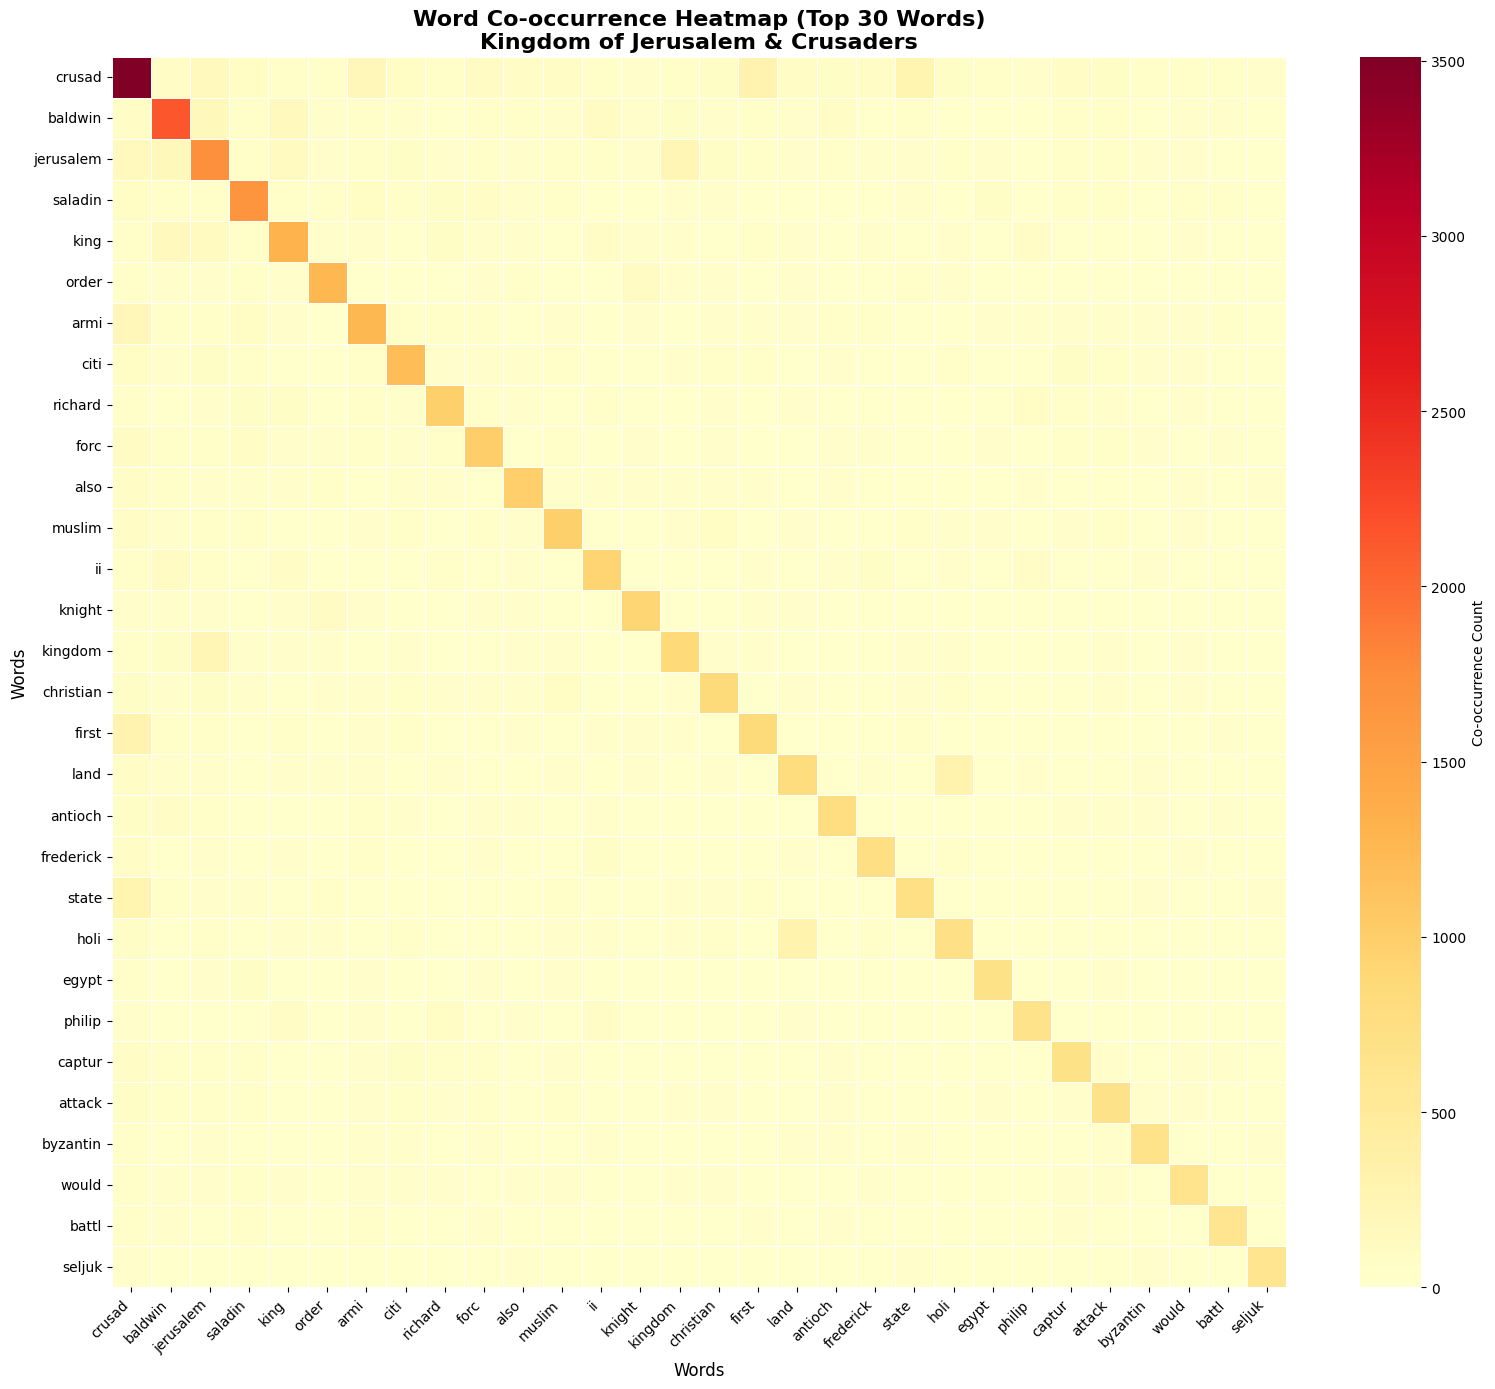

In [26]:
# Visualization 1: Heatmap of top 30x30 words
plt.figure(figsize=(16, 14))
sns.heatmap(cooccurrence_df.iloc[:30, :30].astype(float),
            cmap='YlOrRd',
            linewidths=0.5,
            cbar_kws={'label': 'Co-occurrence Count'})
plt.title('Word Co-occurrence Heatmap (Top 30 Words)\nKingdom of Jerusalem & Crusaders',
          fontsize=16, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

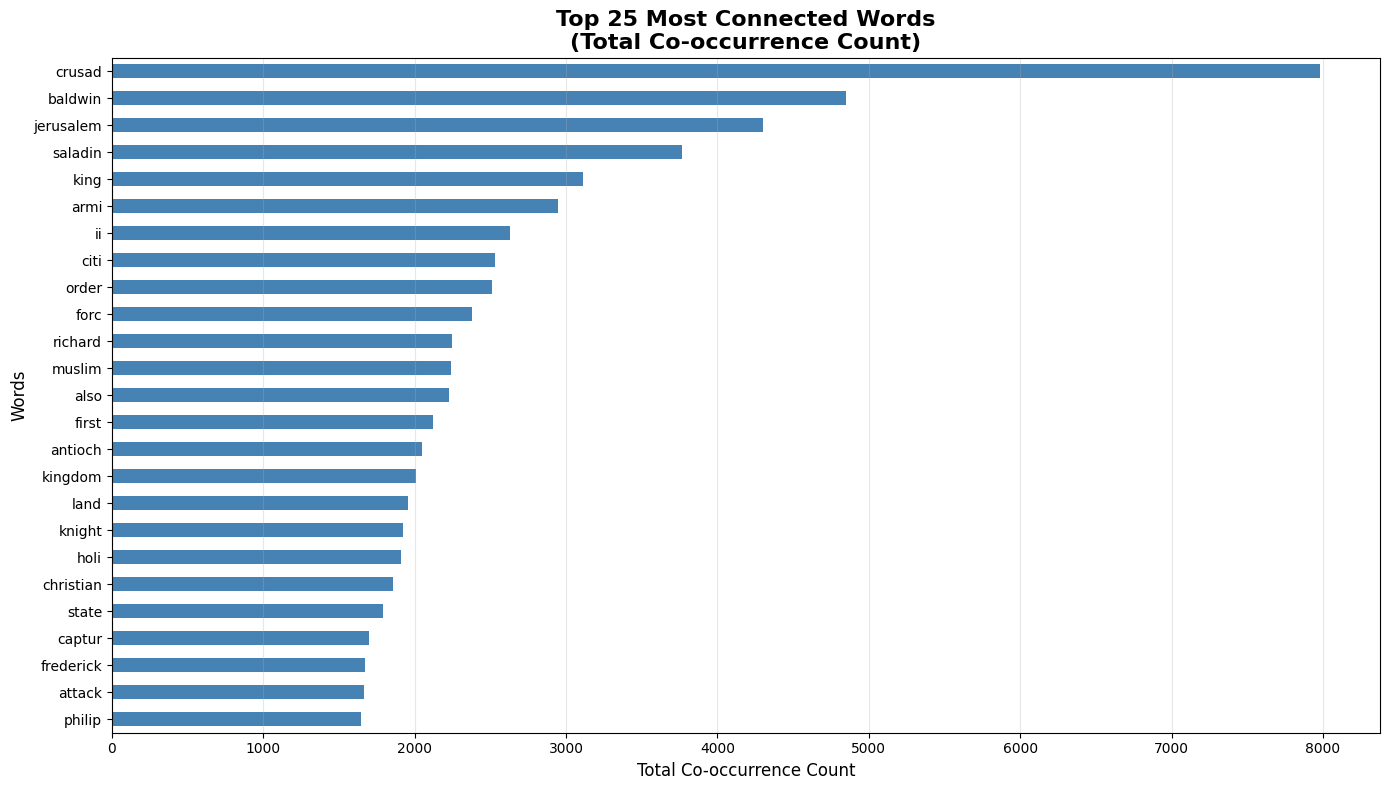

In [27]:
# Visualization 2: Bar chart of most connected words
# Calculate total co-occurrences for each word
word_connectivity = cooccurrence_df.sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(14, 8))
word_connectivity[:25].plot(kind='barh', color='steelblue')
plt.title('Top 25 Most Connected Words\n(Total Co-occurrence Count)',
          fontsize=16, fontweight='bold')
plt.xlabel('Total Co-occurrence Count', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()